[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aalhossary/pyemgpipeline/blob/master/docs/notebooks/ex4_DataProcessingManager.ipynb)

# Example 4 - High-level, guided processing (using knee osteoarthritis therapy data)

This example shows the usage of class
[DataProcessingManager](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#dataprocessingmanager),
a high-level, guided processing interface with accepted EMG processing conventions.
This is the recommended way of EMG processing using this package.

The data used in this example contains 2 of the files of subject #1 from the open access dataset ["Surface electromyography data set of knee osteoarthritis patients undergoing hydrotherapy and physiotherapy rehabilitation routines"](https://zenodo.org/record/5239861) from Zenodo.
In particular, the data was collected in six channels from the lower limbs of the subject before and after the subject received one hydrotherapy.

## Package preparation

We install and import needed packages.

In [1]:
!pip install pyemgpipeline -q

In [2]:
import os
import numpy as np
from matplotlib.figure import SubplotParams
from scipy.io import loadmat
import pyemgpipeline as pep

## Data preparation

First download the raw data from the Zenodo open-access repository.

When finished, the compressed file "Hydrotherapy.rar" (~379MB) is saved in the "knee_oa_therapy" subfolder.

In [3]:
!rm -rf knee_oa_therapy
!wget -q https://zenodo.org/record/5239861/files/Hydrotherapy.rar -P ./knee_oa_therapy

Uncompress the downloaded file. This example will only use two files of subject 1, which are in the archived folder "Hydrotherapy". 

In [4]:
# !unrar x -inul knee_oa_therapy/Hydrotherapy.rar knee_oa_therapy  #This command extracts all files.
!unrar x -inul knee_oa_therapy/Hydrotherapy.rar Hydrotherapy/S1_T1_RF_A.mat Hydrotherapy/S1_T1_RF_B.mat knee_oa_therapy  #This command extracts only the files needed in this example.

Signal data of each trial should be stored in a 2d ndarray with shape *(n_samples, n_channels)*, where each column represents data of one channel.
Data of multiple trials are organized in a *dict* or a *list*.

First we set up basic information of the data, including data path, sample rate, etc.

In [5]:
data_folder = 'knee_oa_therapy/Hydrotherapy'
data_filenames = ['S1_T1_RF_B.mat', 'S1_T1_RF_A.mat']
trial_names = ['Before hydrotherapy', 'After hydrotherapy']
sample_rate = 2000

Signal data of multiple trials are stored in *all_data* of type *list*, where each element of the *list* is a 2d ndarray.

In [6]:
all_data = []
for fn in data_filenames:
    raw = annots = loadmat(os.path.join(data_folder, fn))
    n_channels = 6
    n_blocks = raw['datastart'].shape[1]
    for bk in [3]:
        data_in_list = []
        for ch in range(n_channels):
            start_idx, end_idx = int(raw['datastart'][ch,bk]) - 1, int(raw['dataend'][ch,bk])
            
            data_in_list.append(raw['data'][0, start_idx:end_idx].reshape(-1,1))
        data = np.hstack(data_in_list)
        all_data.append(data)
for i in range(len(all_data)):
    print(all_data[i].shape)

(10000, 6)
(10100, 6)


In [7]:
channel_names = list(raw['titles'][:n_channels])
channel_names

['Tibial Anterior     ',
 'Soleo               ',
 'Gastrocnemio Medial ',
 'Gastrocnemio Lateral',
 'Vasto Medial        ',
 'Biceps Femoral      ']

In [8]:
all_data

[array([[ 0.00095102, -0.00036325,  0.00158556,  0.00113706,  0.00039269,
          0.00086887],
        [ 0.00096039, -0.00037888,  0.00159493,  0.00114644,  0.00037394,
          0.00081575],
        [ 0.00097289, -0.00036013,  0.00161681,  0.00112769,  0.00033644,
          0.00085325],
        ...,
        [ 0.00048853, -0.00052723,  0.00136287,  0.00152569,  0.00022803,
          0.00052072],
        [ 0.00039166, -0.00049598,  0.00138162,  0.00156944,  0.00030303,
          0.00058947],
        [ 0.00038228, -0.0005491 ,  0.00138787,  0.00166319,  0.00039053,
          0.00058635]], dtype=float32),
 array([[ 4.5427226e-04, -8.2309276e-04,  1.2369723e-03,  1.0908389e-03,
          1.6877582e-04,  9.8513823e-04],
        [ 5.1052228e-04, -8.3246781e-04,  1.2463472e-03,  1.1095889e-03,
          1.3440082e-04,  9.4138819e-04],
        [ 4.4802227e-04, -8.1059278e-04,  1.2275972e-03,  1.1033389e-03,
          1.3752581e-04,  9.6951320e-04],
        ...,
        [ 1.4278939e-04, -3.43

In [9]:
print('shapes of all_data:', all_data[0].shape, all_data[1].shape)

shapes of all_data: (10000, 6) (10100, 6)


We also set up the parameters for plotting with an instance of class
[EMGPlotParams](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.plots.html#emgplotparams).
Note that the whole setting configures the plotting of a single trial. Plotting of all trials use the same setting.

In [10]:
emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=3,
    n_cols=2,
    fig_kwargs={
        'figsize': (16, 4),
        'subplotpars': SubplotParams(top=0.8, wspace=0.1, hspace=0.4),
    }
)

## Data processing

First we create an instance of class
[DataProcessingManager](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#dataprocessingmanager).

In [11]:
mgr = pep.wrappers.DataProcessingManager()

We use method *set_data_and_params* to set or reset signal data *all_data*, timestamp data *all_timestamp*, and other information, to the data processing manager instance.

In [12]:
mgr.set_data_and_params(all_data, hz=sample_rate, trial_names=trial_names,
                        channel_names=channel_names, emg_plot_params=emg_plot_params)

Note that the above method also initializes five processing steps as default in case they are not set yet. The steps can be examined as follows:

In [13]:
mgr.show_current_processes_and_related_params()

---- Current processes and related parameters ----
DC offset remover    : No parameters
Bandpass filter      : hz = 2000, bf_order = 4, bf_cutoff_fq_lo = 10, bf_cutoff_fq_hi = 450
Full wave rectifier  : No parameters
Linear envelope      : hz = 2000, le_order = 4, le_cutoff_fq = 6
End frame cutter     : n_end_frames = 30


The data processing manager instance contains instances of all processors (which can be None), including
[DCOffsetRemover](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#dcoffsetremover),
[BandpassFilter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#bandpassfilter),
[FullWaveRectifier](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#fullwaverectifier),
[LinearEnvelope](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#linearenvelope),
[EndFrameCutter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#endframecutter),
[AmplitudeNormalizer](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#amplitudenormalizer),
and
[Segmenter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#segmenter).
All of them can be set or reset.

We set the
[AmplitudeNormalizer](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#amplitudenormalizer)
processor, which will calculate the maximum amplitude of each channel across trials for normalization.

In [14]:
mgr.set_amplitude_normalizer(pep.processors.AmplitudeNormalizer())
mgr.show_current_processes_and_related_params()

---- Current processes and related parameters ----
DC offset remover    : No parameters
Bandpass filter      : hz = 2000, bf_order = 4, bf_cutoff_fq_lo = 10, bf_cutoff_fq_hi = 450
Full wave rectifier  : No parameters
Linear envelope      : hz = 2000, le_order = 4, le_cutoff_fq = 6
End frame cutter     : n_end_frames = 30
Amplitude normalizer : No parameters


The *process_all* method is responsible for applying all processors in the predefined sequence. With the parameter *is_plot_processing_chain* being True, the original data and intermediate data after each step will be displayed.

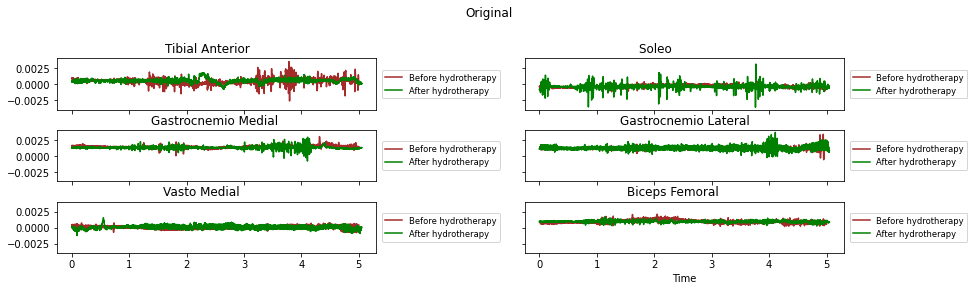

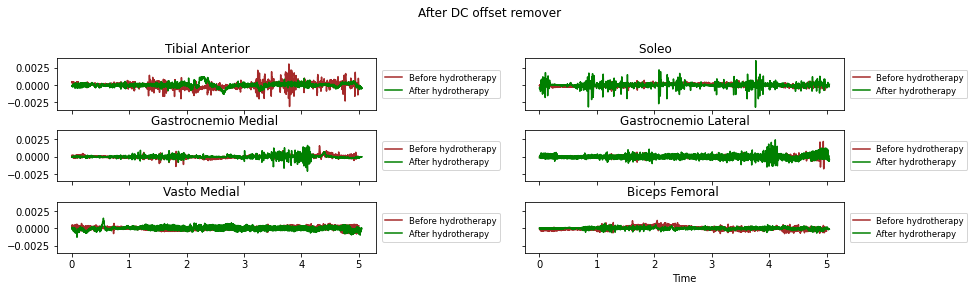

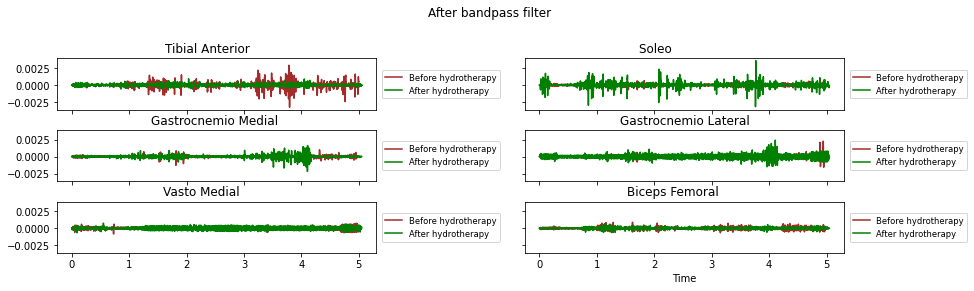

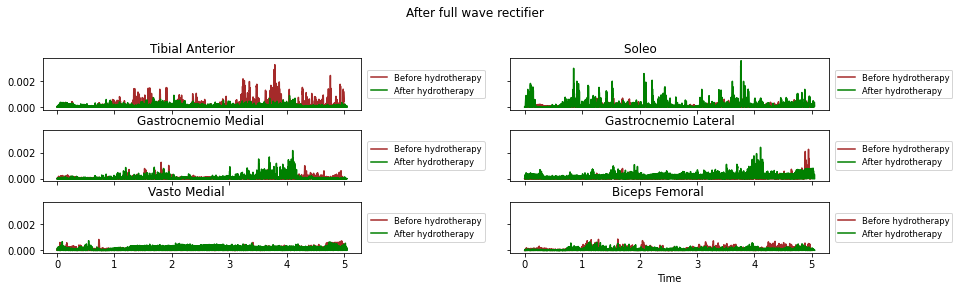

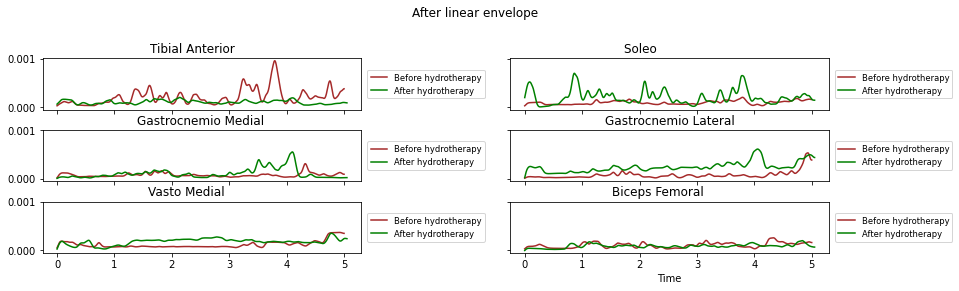

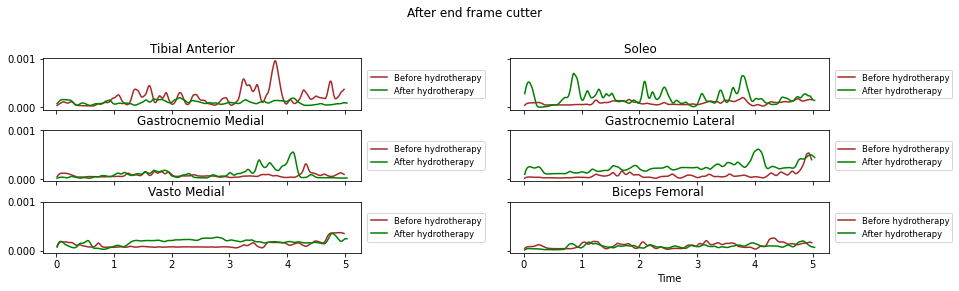

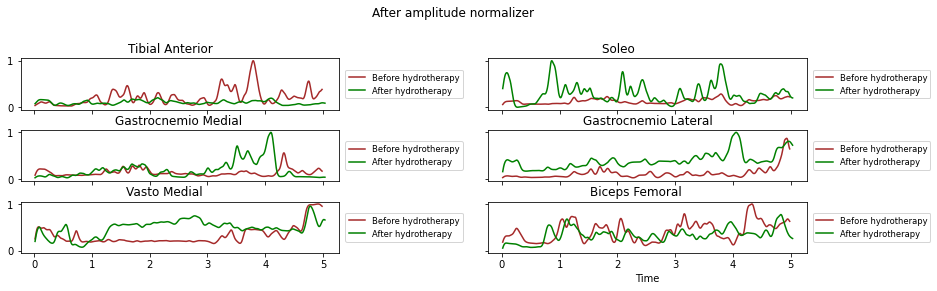

In [15]:
c = mgr.process_all(is_plot_processing_chain=True, is_overlapping_trials=True,
                    cycled_colors=['brown', 'green'],
                    legend_kwargs={'loc':'right', 'bbox_to_anchor':(1.4, 0.5), 'fontsize':'small'},
                    axes_pos_adjust=(0, 0, 0.75, 1))

The processed results from method *process_all* is saved in *c* of type
[EMGMeasurementCollection](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#emgmeasurementcollection),
which possesses methods *plot*, *export_csv*, and the indexing operator *[]* for furtuer use.

In [16]:
isinstance(c, pep.wrappers.EMGMeasurementCollection)

True